## Классификация текстов с использованием предобученных языковых моделей.

В данном задании вам предстоит обратиться к задаче классификации текстов и решить ее с использованием предобученной модели BERT.

In [1]:
import json
# do not change the code in the block below
# __________start of block__________
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

%matplotlib inline
# __________end of block__________

Обратимся к набору данных SST-2. Holdout часть данных (которая понадобится вам для посылки) доступна по ссылке ниже.

In [2]:
# do not change the code in the block below
# __________start of block__________

!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/24f_yandex_ml_trainings/homeworks/hw04_bert_and_co/texts_holdout.json
# __________end of block__________

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [3]:
# do not change the code in the block below
# __________start of block__________
df = pd.read_csv(
    "https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv",
    delimiter="\t",
    header=None,
)
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]
with open("texts_holdout.json") as iofile:
    texts_holdout = json.load(iofile)
# __________end of block__________

Весь остальной код предстоит написать вам.

Для успешной сдачи на максимальный балл необходимо добиться хотя бы __84.5% accuracy на тестовой части выборки__.

In [4]:
from transformers import BertModel, BertTokenizer

device = torch.device('cuda')

c:\STUDYING\8()last\MLhw\NLP1\nnnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
bert = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

bert = bert.to(device)

tokenized_texts_train = tokenizer(texts_train.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=512)
tokenized_texts_test = tokenizer(texts_test.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=512)
tokenized_holdout = tokenizer(texts_holdout, padding=True, truncation=True, return_tensors='pt', max_length=512)

tokenized_texts_train = {key: value.to(device) for key, value in tokenized_texts_train.items()}
tokenized_texts_test = {key: value.to(device) for key, value in tokenized_texts_test.items()}
tokenized_texts_holdout = {key: value.to(device) for key, value in tokenized_holdout.items()}

with torch.no_grad():
    embeddings_texts_train = bert(**tokenized_texts_train).last_hidden_state
    embeddings_texts_test = bert(**tokenized_texts_test).last_hidden_state
    embeddings_texts_holdout = bert(**tokenized_texts_holdout).last_hidden_state

In [6]:
X_train_tensor = embeddings_texts_train.permute(0, 2, 1)
X_test_tensor = embeddings_texts_test.permute(0, 2, 1)
X_holdout_tensor = embeddings_texts_holdout.permute(0, 2, 1)

y_train_tensor = torch.tensor(y_train, dtype=torch.int64).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64).to(device)

In [7]:
X_train_tensor.shape

torch.Size([5000, 768, 67])

In [8]:
my_model = nn.Sequential(
    nn.Conv1d(in_channels=768, out_channels=4, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm1d(4),
    nn.Dropout(0.5),
    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(4, 2)
).to(device)

loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(my_model.parameters())


In [9]:
from IPython import display

In [10]:
def plot_train_process(
    train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=""
):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(" ".join(["Loss", title_suffix]))
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title(" ".join(["Validation accuracy", title_suffix]))
    axes[1].plot(train_accuracy, label="train")
    axes[1].plot(val_accuracy, label="validation")
    axes[1].legend()
    plt.show()

In [ ]:
def train_model(
		model,
		opt,
		X_train_tensor,
		y_train_tensor,
		X_test_tensor,
		y_test_tensor,
		n_iterations = 150,
		batch_size = 512,
		eval_every=5,
) -> nn.Module:
	train_loss_history = []
	test_loss_history = []
	train_acc_history = []
	test_acc_history = []

	local_train_loss_history = []
	local_train_acc_history = []

	for iter in np.arange(n_iterations):
		ix = np.random.randint(0, len(X_train_tensor), batch_size)
		x_batch = X_train_tensor[ix]
		y_batch = y_train_tensor[ix]

		y_pred_batch = model(x_batch)
		
		loss = loss_func(y_pred_batch, y_batch)
		loss.backward()
		opt.step()
		opt.zero_grad()

		local_train_loss_history.append(loss.item())
		local_train_acc_history.append(
			accuracy_score(
				y_batch.to('cpu').detach().numpy(),
				y_pred_batch.to('cpu').detach().numpy().argmax(axis=1)
			)
		)

		if iter % eval_every == 0:
			train_loss_history.append(np.mean(local_train_loss_history))
			train_acc_history.append(np.mean(local_train_acc_history))
			local_train_loss_history, local_train_acc_history = [], []

			predictions_val = model(X_test_tensor)
			test_loss_history.append(loss_func(predictions_val, y_test_tensor).to('cpu').detach().item())

			acc_score_val = accuracy_score(y_test_tensor.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
			test_acc_history.append(acc_score_val)

			display.clear_output(wait=True)
			plot_train_process(train_loss_history, test_loss_history, train_acc_history, test_acc_history)
	print(acc_score_val)
	return model


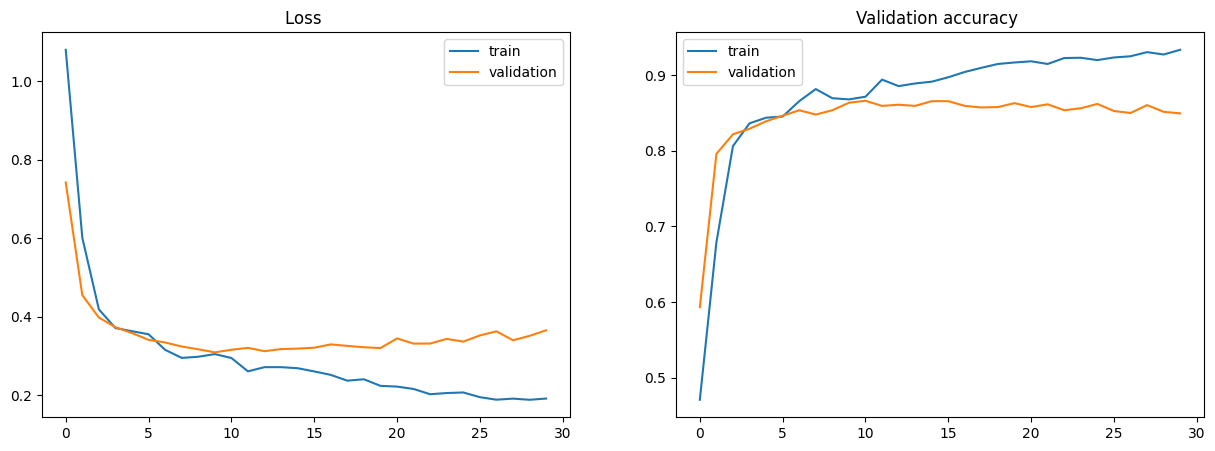

0.8494791666666667


In [12]:
fine_model = train_model(
    my_model,
    opt,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
)


#### Сдача взадания в контест
Сохраните в словарь `out_dict` вероятности принадлежности к первому (положительному) классу

In [13]:
def get_probas(model, X_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probas_batch = torch.sigmoid(outputs)[:, 1].cpu().numpy()
        return probas_batch



train_probas = get_probas(fine_model, X_train_tensor)
test_probas = get_probas(fine_model, X_test_tensor)
holdout_probas = get_probas(fine_model, X_holdout_tensor)

out_dict = {
    'train': train_probas.tolist(),
    'test': test_probas.tolist(),
    'holdout': holdout_probas.tolist()
}


Несколько `assert`'ов для проверки вашей посылки:

In [14]:
assert isinstance(out_dict["train"], list), "Object must be a list of floats"
assert isinstance(out_dict["train"][0], float), "Object must be a list of floats"
assert (
    len(out_dict["train"]) == 5000
), "The predicted probas list length does not match the train set size"

assert isinstance(out_dict["test"], list), "Object must be a list of floats"
assert isinstance(out_dict["test"][0], float), "Object must be a list of floats"
assert (
    len(out_dict["test"]) == 1920
), "The predicted probas list length does not match the test set size"

assert isinstance(out_dict["holdout"], list), "Object must be a list of floats"
assert isinstance(out_dict["holdout"][0], float), "Object must be a list of floats"
assert (
    len(out_dict["holdout"]) == 500
), "The predicted probas list length does not match the holdout set size"

Запустите код ниже для генерации посылки.

In [15]:
# do not change the code in the block below
# __________start of block__________
FILENAME = "submission_dict_hw_text_classification_with_bert.json"

with open(FILENAME, "w") as iofile:
    json.dump(out_dict, iofile)
print(f"File saved to `{FILENAME}`")
# __________end of block__________

File saved to `submission_dict_hw_text_classification_with_bert.json`


На этом задание завершено. Поздравляем!